In [1]:
%load_ext autoreload
%autoreload 2

# Visualization of the Statistical Manifold

In this notebook, we will visualize the different Riemannian structures on the statistical manifold of a categorical distribution. SFM assumes that the statistical manifold is equipped with the Fisher information metric. LinearFM, on the other hand, assumes an underlying Euclidean structure that inherits the canonical Euclidean metric. We will show the geodesic distance, the exponential map (geodesics), and the logarithm map (vector fields).

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from models import SimplexCategoricalFlow, LinearCategoricalFlow

In [3]:
r0 = np.array([0, 0])
r1 = np.array([1, 0])
r2 = np.array([1 / 2., np.sqrt(3) / 2.])
corners = np.array([r0, r1, r2])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)


def xy2ba(x, y):
    corner_x = corners.T[0]
    corner_y = corners.T[1]
    x_1 = corner_x[0]
    x_2 = corner_x[1]
    x_3 = corner_x[2]
    y_1 = corner_y[0]
    y_2 = corner_y[1]
    y_3 = corner_y[2]
    l1 = ((y_2 - y_3) * (x - x_3) + (x_3 - x_2) * (y - y_3)) / (
            (y_2 - y_3) * (x_1 - x_3) + (x_3 - x_2) * (y_1 - y_3))
    l2 = ((y_3 - y_1) * (x - x_3) + (x_1 - x_3) * (y - y_3)) / (
            (y_2 - y_3) * (x_1 - x_3) + (x_3 - x_2) * (y_1 - y_3))
    l3 = 1 - l1 - l2
    return np.clip(np.stack([l1, l2, l3], axis=-1), 0, 1)


def ba2xy(x):
    x = np.array(x)
    return x.dot(corners)


def plot_simplex(ax):
    ax.triplot(triangle, linewidth=0.8, color='black')
    ax.axis('equal')
    ax.axis('off')
    margin = 0.01
    ax.set_ylim(ymin=-margin, ymax=r2[1] + margin)
    ax.set_xlim(xmin=-margin, xmax=1. + margin)
    ax.annotate('y', (0, 0), xytext=(-0.0, -0.02), horizontalalignment='center', va='top')
    ax.annotate('z', (1, 0), xytext=(1.0, -0.02), horizontalalignment='center', va='top')
    ax.annotate('x', corners[2], xytext=corners[2] + np.array([0.0, 0.02]), horizontalalignment='center', va='bottom')

## Geodesic distance

We plot the contour of the geodesic distance between a fixed target distribution (uniform distribution) and the categorical distribution on the simplex.

In [4]:
trimesh = refiner.refine_triangulation(subdiv=5)
source = torch.from_numpy(xy2ba(trimesh.x, trimesh.y))
target = torch.ones(1, 3, dtype=torch.double) / 3

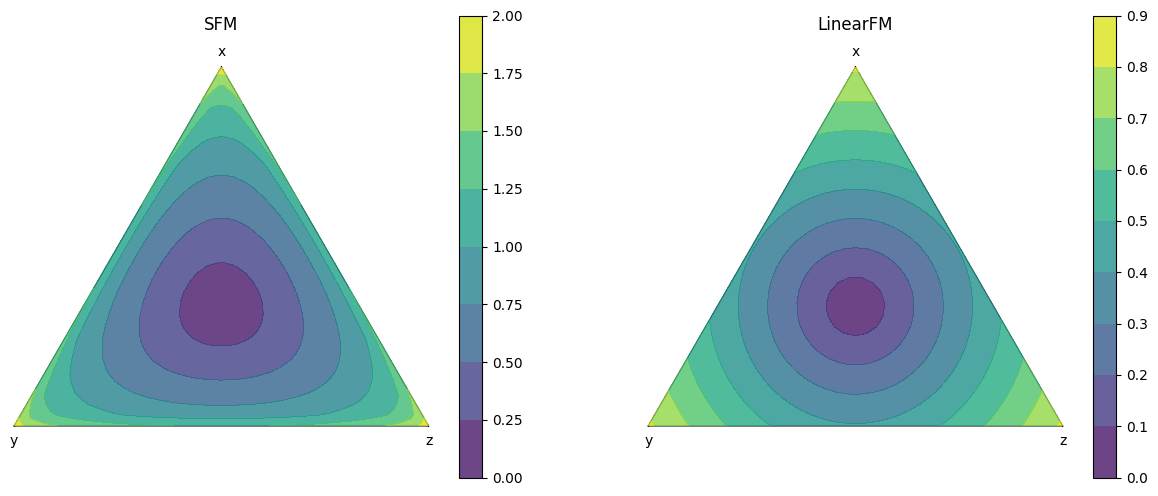

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_simplex(ax1)
d1 = SimplexCategoricalFlow.dist(source, target, eps=0.)
contour1 = ax1.tricontourf(trimesh, d1, alpha=0.8, cmap='viridis')
plt.colorbar(contour1, ax=ax1)
ax1.set_title('SFM', y=0.95)
plot_simplex(ax2)
d2 = LinearCategoricalFlow.dist(source, target, eps=0.)
contour2 = ax2.tricontourf(trimesh, d2, alpha=0.8, cmap='viridis')
plt.colorbar(contour2, ax=ax2)
ax2.set_title('LinearFM', y=0.95)
plt.show()

## Exponential Map (Geodesics)

We plot the geodesics between the fixed source distribution (uniform distribution) and target distributions on the simplex using the exponential map by interpolating the geodesic distance. The points on the simplex is colored by the interpolation parameter $t$ and are equally spaced with respect to the corresponding geodesic distance.

In [6]:
eps = 1e-4
source = torch.ones(1, 1, 3, dtype=torch.double) / 3
target = torch.tensor([
    [1 - eps * 2, eps, eps],
    [2 / 3, 1 / 3 - eps, eps],
    [1 / 3, 2 / 3 - eps, eps],
    [eps, 1 - eps * 2, eps],
    [eps, 2 / 3, 1 / 3 - eps],
    [eps, 1 / 3, 2 / 3 - eps],
    [eps, eps, 1 - eps * 2],
    [1 / 3 - eps, eps, 2 / 3 - eps],
    [2 / 3 - eps, eps, 1 / 3 - eps]
]).unsqueeze(1)
t = torch.linspace(0, 1, 20, dtype=torch.double).unsqueeze(0)

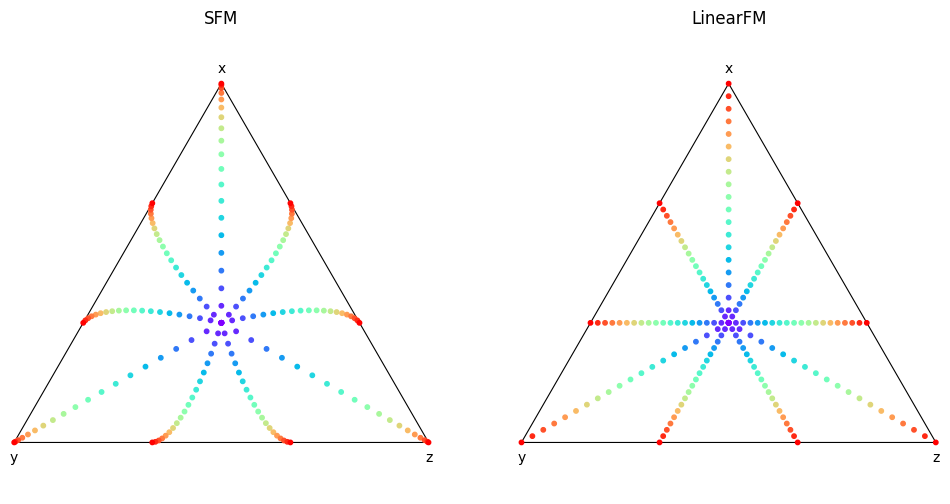

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_simplex(ax1)
interpolation1 = SimplexCategoricalFlow.interpolate(source, target, t, eps=eps)
for i in range(interpolation1.size(0)):
    pt = ba2xy(interpolation1[i])
    ax1.scatter(pt[:, 0], pt[:, 1], c=t, cmap='rainbow', s=10)
ax1.set_title('SFM')
plot_simplex(ax2)
interpolation2 = LinearCategoricalFlow.interpolate(source, target, t, eps=eps)
for i in range(interpolation2.size(0)):
    pt = ba2xy(interpolation2[i])
    ax2.scatter(pt[:, 0], pt[:, 1], c=t, cmap='rainbow', s=10)
ax2.set_title('LinearFM')
plt.show()

## Logarithm Map (Vector Fields)

We plot the logarithm map from the source distributions to a fixed target distribution (uniform distribution). The conditional vector field can be calculated as $u(\mu_t|\mu_1)=\frac{1}{1-t}\log_{\mu_t}\mu_1$, sharing the same direction as the logarithm map.

In [8]:
trimesh = refiner.refine_triangulation(subdiv=4)
source = torch.from_numpy(xy2ba(trimesh.x, trimesh.y))
target = torch.ones(1, 3, dtype=torch.double) / 3

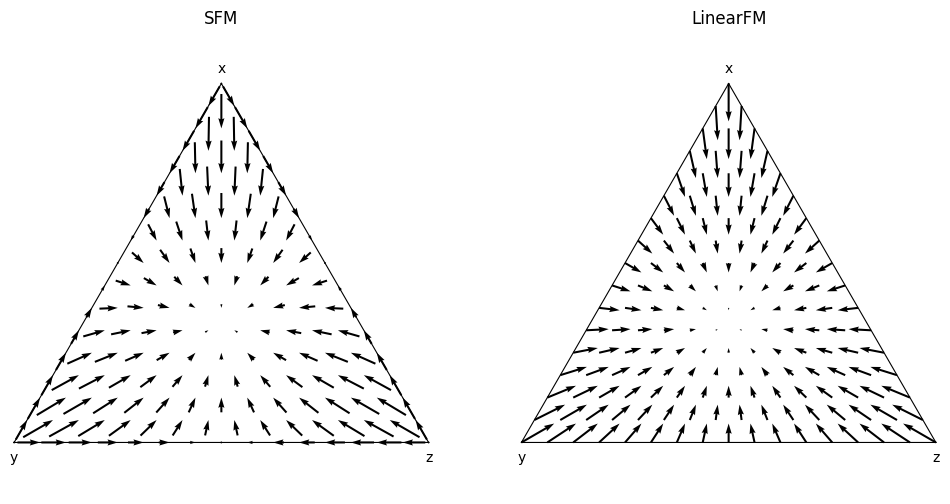

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_simplex(ax1)
vf1 = ba2xy(SimplexCategoricalFlow.log(source, target, eps=0.))
ax1.quiver(trimesh.x, trimesh.y, vf1[:, 0], vf1[:, 1], angles='xy', pivot='tip')
ax1.set_title('SFM')
plot_simplex(ax2)
vf2 = ba2xy(LinearCategoricalFlow.log(source, target, eps=0.))
ax2.quiver(trimesh.x, trimesh.y, vf2[:, 0], vf2[:, 1], angles='xy', pivot='tail')
ax2.set_title('LinearFM')
plt.show()